# Environment setup

In [1]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Library preparation

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
import time, os, io, clipboard
from PIL import ImageGrab
from IPython.display import Image, display
from scipy import stats
from si_prefix import si_format
from math import *
from tqdm import tqdm, tqdm_notebook

from io import StringIO 
import pandas as pd
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('..\_jjtools')

from JJ_data_processing import *
from JJformulas import *


from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment, experiments)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

### Database ini

In [ ]:
SAMPLE = 'D078N5'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

In [9]:
SAMPLE = 'D078N5'


qc.config["core"]["db_location"] = os.getcwd() + '\..\..\ExdData\Experiments_{}.db'.format(SAMPLE)

## Scripts

### Data proc

In [ ]:
def cos_to_B( cos , ZF = 4e-6, FF = 214e-6):

    return np.arccos(cos)*(2* (FF - ZF)/np.pi + ZF  )

In [ ]:
def JJpar(RN, JJwidthUM=0.2, metalTHK=250E-10, Tc=1.34):
   
    Rs_JJ = RN * ( (JJwidthUM*1E-6 + 2*metalTHK) *JJwidthUM*1E-6 )
    IAB = const.pi *1.764 *const.k *Tc /2 /const.e /RN
    EJ_JJ = const.h /2 /const.e /2 /const.pi *IAB
    C_JJ = 50E-15 *JJwidthUM *JJwidthUM
    EC_JJ = const.e *const.e /2 /C_JJ
    C0 = ParplateCap(area= 56*1E-12 , dielecTHK=10E-9, epsilon = 9.34*const.epsilon_0)
    EC0 = const.e *const.e /2 /C0
   
    freqPlasma = sqrt(2 *const.e *IAB *2*const.pi /const.h /max(C0,C_JJ)) /2/const.pi
    Q = freqPlasma*2*pi *RN *max(C0,C_JJ)
    EJoEc = EJ_JJ/min(EC0,EC_JJ)

#     key =  [ 'RN_JJ',   'Rs_JJ', 'I_AB',   'EJ', 'C_JJQP',   'EC', 'C0', 'EC0', 'Freq_plasma', 'Q', 'Beta', 'EJ/EC']
#     unit=  [   'ohm', 'ohm-m^2',    'A',    'J',      'F',    'J',  'F',   'J',          'Hz',  '',     '',      '']
#     lst = [[     RN ,    Rs_JJ ,   IAB , EJ_JJ ,    C_JJ , EC_JJ ,  C0 ,  EC0 ,    freqPlasma,  Q ,   Q*Q ,  EJoEc ]]
    key =  [ 'RN_JJ',    'Rs_JJ', 'I_AB',           'EJ',  'C_JJQP',          'EC',    'C0',       'EC0',  'Freq_plasma', 'Q', 'Beta', 'EJ/EC']
    unit=  [  'kohm','kohm*um^2',   'nA',            'K',      'fF',           'K',    'fF',         'K',          'GHz',  '',     '',      '']
    lst = [[ RN/1e3 , Rs_JJ*1e9 ,IAB*1e9, EJ_JJ/const.k , C_JJ*1e15, EC_JJ/const.k, C0*1e15, EC0/const.k, freqPlasma/1e9,  Q ,   Q*Q ,  EJoEc ]]
    JJparDFM =   pd.DataFrame(  data  = list(zip(*lst)),
                                index = key ).transpose()
    JJparUNI =   dict(zip(key, unit))

    return JJparDFM,JJparUNI

def ParplateCap(area, dielecTHK, epsilon = 9.34*const.epsilon_0):
    C = epsilon *area /dielecTHK
    return C

In [ ]:
devlst = {'D079N1': JJpar(RN=  290e3/.5, JJwidthUM=np.sqrt( .177 *  .177)),
          'D079N3': JJpar(RN=  520e3/ 8, JJwidthUM=np.sqrt( .784 *  .263)),
          'D079N5': JJpar(RN=   27e3/ 8, JJwidthUM=np.sqrt( 2.25 *  1.74)),
          'D079N6': JJpar(RN= 2.15e3/.5, JJwidthUM=np.sqrt( 2.21 *  1.72)),
          'D079N0': JJpar(RN= 24.3e3/ 8, JJwidthUM=np.sqrt( 2.21 *  1.67))}

a     = devlst['D079N1'][0]
unit  = devlst['D079N1'][1]
idlst = []
for dev in devlst:
    a = a.merge(devlst[dev][0], 'outer')
    idlst.append(dev)
   
a.insert(loc = 0, column = 'dev id', value = idlst)
a

#### Hist

In [14]:
def load_hist_by_id(idx):
    _, Isws = xy_by_id(idx)
    return Isws

In [15]:
def plot_hist_by_id(idx, ax = None, cumulative = False ):
    _, Isws = xy_by_id(idx)
    if ax is None:

        fig, ax = plt.subplots()

    ax.hist(Isws, bins = 201, cumulative = cumulative )
    return Isws

In [16]:
def save_hist(Isws, label = ''):     
    N_try = qc.Parameter('try')    

    meas = set_meas( Isrc.I, N_try, setup = setup, cleanup = cleanup)
    name = '{:} @T ={:2.1f}mK'.format(label, T8.get()/1e-3)
    name_exp(sample = SAMPLE, exp_type = name )  
    with meas.run() as datasaver: 
        for j, I in enumerate(Isws):
            res = [ ( N_try, j  ) ,( Isrc.I, I ),]

            datasaver.add_result(*res)
            
    print('Run # {:1.0f}, {:} saved'.format(datasaver.run_id, name))

In [17]:
def fit_hist_by_id(idx, EJ = 4, Ec = 0.05, dIdt = 30e-9, bins = 21):

    def wpK(EjK, EcK):
        return np.sqrt(8*EjK*EcK)
    
    eps = .001
    
    Isw = abs(load_hist_by_id(idx ))

    counts, Ibins = np.histogram(Isw, bins = bins)
    dI = np.mean( np.diff(Ibins) )

    SP = np.cumsum(counts)/len(Isw)
    Gamma = np.array([ np.log( (1 - SP[i])/(1 - SP[i+1]) ) for i in range(len(SP)-1)  ])*dIdt/dI


    Ic = 2*pi*EJ/Φ0*kB
    Ic0 = 1.5 * np.max(Isw)
    Ib = Ibins[:-2]
    
    while abs((Ic - Ic0)/Ic) > eps:
        Ic = Ic0
        wa = wpK(EJ, Ec)*kB/hbar/2/pi * (1 - (Ib/Ic)**2)**0.25

        coeff =  (-np.log(2*pi*Gamma/wa))**(2/3)
        i = np.isfinite(coeff) 
        
        a, b = np.polyfit( Ib[i], coeff[i],1)
        Ic0 = -b/a
        Teff = -1/kB*Φ0/2/pi*4*np.sqrt(2)/3 /np.sqrt(b)/a
    

    return Ic0, Teff

# Sample discription and runid matrix

## Sample description matrix

In [21]:
#D078 wet oxygen 375 torr, 30min. Recorded on 191121, dep by Plamen. dim corrected by SEM
devlst = {'D078N5': JJpar(RN= 142.6e3/ 8, JJwidthUM=np.sqrt( 2.23 *  1.73), metalTHK=250E-10, Tc=1.34),
          'D078N6': JJpar(RN=  10.4e3/.5, JJwidthUM=np.sqrt( 2.24 *  1.61), metalTHK=250E-10, Tc=1.34),
          'D078N8': JJpar(RN=   315e3/ 8, JJwidthUM=np.sqrt( 1.44 *  1.17), metalTHK=250E-10, Tc=1.34),
          'D078N0': JJpar(RN= 147.5e3/ 8, JJwidthUM=np.sqrt( 2.28 *  1.69), metalTHK=250E-10, Tc=1.34)}

D078 = devlst['D078N5'][0]
idlst = []
for dev in devlst:
    D078 = D078.merge(devlst[dev][0], 'outer')
    idlst.append(dev)
D078.insert(loc = 0, column = 'dev id', value = idlst)

In [22]:
print(D078[D078['dev id'] == SAMPLE]['EJ'])
D078[D078['dev id'] == SAMPLE]

0    0.427877
Name: EJ, dtype: float64


dev id   RN_JJ     Rs_JJ       I_AB        EJ   C_JJQP        EC  \
0  D078N5  17.825  70.51762  17.950083  0.427877  192.895  0.004819   

          C0       EC0  Freq_plasma          Q         Beta      EJ/EC  
0  463.10944  0.002007     1.727204  89.585289  8025.524069  213.15478

## Run id matrix

In [17]:
ZF = 0.0e-3
FF = 0.218e-3
# dF = 0.250e-3
# midF = 0.154e-3

keys  = [             'ids',    'T',  'B',                                 'comment']
valss = [[range( 63,  90+1),  32e-3,  np.linspace(  0e-6,270e-6,28),       'fast 4'],
         [range( 91,  93+1),  32e-3,  np.linspace(230e-6,270e-6, 3),       'fast 6'],
         [range( 94, 118+1),  32e-3,  np.linspace(200e-6,260e-6,25),       'fast 4'],
         [range(237, 262+1),  32e-3,  cos_to_B(np.linspace(1,0,26)),       'fast 6, I_div'],
         [range(263, 288+1),  32e-3,  cos_to_B(np.linspace(1,0,26)),       'AWG att 1, R=1G'],
         [range(320, 345+1),  32e-3,  cos_to_B(np.linspace(1,0,26)),       'AWG att 100, R=10M'],
         [range(352, 377+1),  32e-3,  cos_to_B(np.linspace(1,0,26)),       'AWG att 10, R=100M'],

        ]

exps78N5 = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]
exps78N5_pd = pd.DataFrame(  data  = list(zip(*valss)), index = keys ).transpose()## Run id matrix

NameError: name 'cos_to_B' is not defined

# Meas

<IPython.core.display.Javascript object>


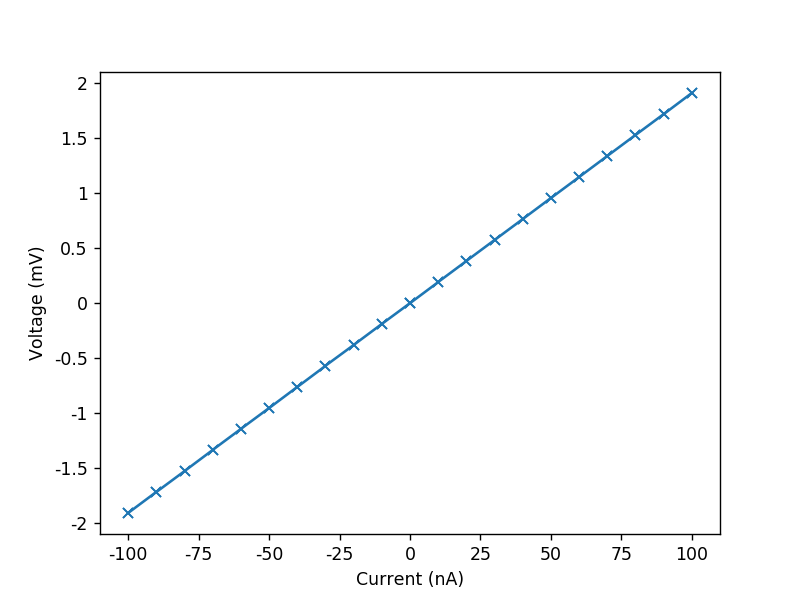

R_4pb = 19.1 kohm


In [10]:
plot_by_id(2, marker = 'x')
print('R_4pb = {}ohm'.format(si_format(np.polyfit(xy_by_id(2)[0],
                                                  xy_by_id(2)[1],1)[0])))

<IPython.core.display.Javascript object>


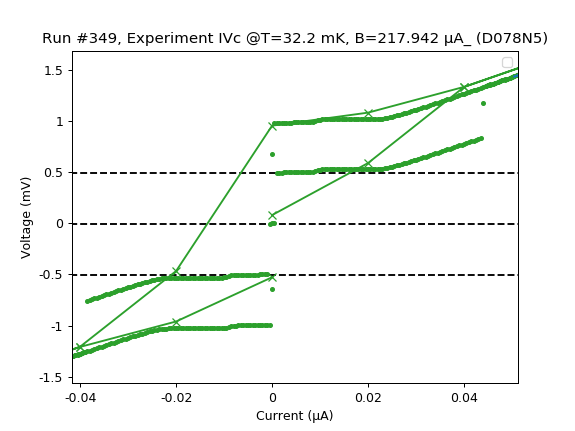

No handles with labels found to put in legend.


R_pos = 16.7 kohm/JJ, V_off = 93.5 µV/JJ
R_neg = 16.7 kohm/JJ, V_off = -100.2 µV/JJ
C/JJ from 1e/V_off : 1.7 fF


In [19]:
plt.close('all')
f,ax = plt.subplots()

I,V = xy_by_id(10)

batch_plot_by_id([10], ax = ax, marker = '.', ls='None', color='C2')
# ax.plot(I, V-495e-6, marker = '.', ls='None', color='C2')

datSel = np.where(I > 50e-9, True, False)
a_p, b_p = np.polyfit(I[datSel], V[datSel], 1)
ax.plot(I[datSel], I[datSel]*a_p + b_p)

datSel = np.where(I < -50e-9, True, False)
a_n, b_n = np.polyfit(I[datSel], V[datSel], 1)
ax.plot(I[datSel], I[datSel]*a_n + b_n)

print('R_pos = {}ohm/JJ, V_off = {}V/JJ'.format(si_format(a_p), si_format(b_p-497e-6)))
print('R_neg = {}ohm/JJ, V_off = {}V/JJ'.format(si_format(a_n), si_format(b_n+497e-6)))
print('C/JJ from 1e/V_off : {}F'.format(si_format(1*const.e/((b_p-b_n)/2-497e-6))))

gap = 495e-6
offset = -6e-6
fr = 20e-6
N = 1

for i in range(-N,N+1,1):
    ax.hlines(i*gap  +offset,                   -100e-9,100e-9,
              alpha = 1, ls = '--')

    
    
plot_by_id(349, axes = ax , marker = 'x')
plt.show()

In [35]:
480/32

15.0

In [39]:
(2.71+2.88)/2/30

0.09316666666666666

In [36]:
(4.06+5.89)/2/30

0.16583333333333333

<IPython.core.display.Javascript object>


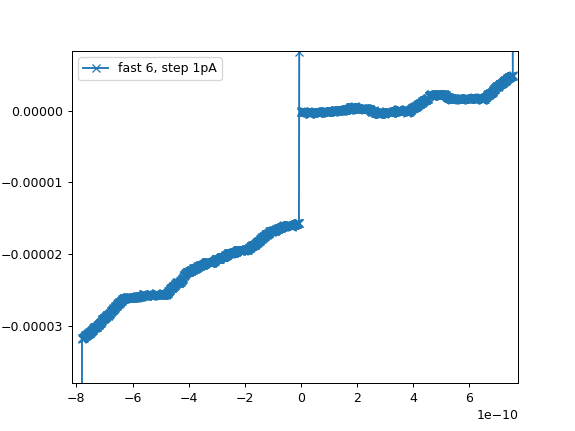

In [21]:
plt.close('all')
f,ax=plt.subplots()
# ax.plot(xy_by_id( 3)[0],xy_by_id( 3)[1], marker = 'x', label = 'fast 6, step 10pA')
ax.plot(xy_by_id(11)[0],xy_by_id(11)[1], marker = 'x', label = 'fast 6, step 1pA')
# ax.plot(xy_by_id(15)[0],xy_by_id(15)[1], marker = 'x', label = 'fast 4, step 1pA')
# ax.plot(xy_by_id(63)[0],xy_by_id(63)[1], marker = 'x', label = 'fast 4, step 2pA')
# ax.plot(xy_by_id(10)[0],xy_by_id(10)[1], marker = 'x')

ax.legend()
plt.show()

<IPython.core.display.Javascript object>


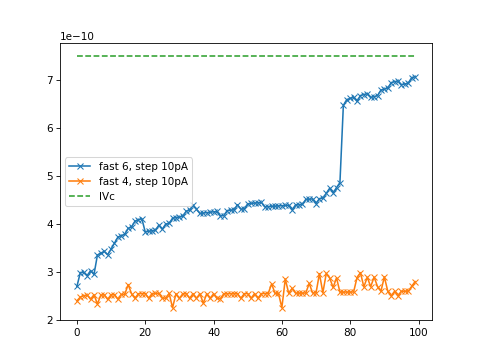

In [81]:
plt.close('all')
f,ax=plt.subplots()
ax.plot(xy_by_id(13)[0],xy_by_id(13)[1], marker = 'x', label = 'fast 6, step 10pA')
ax.plot(xy_by_id(14)[0],xy_by_id(14)[1], marker = 'x', label = 'fast 4, step 10pA')
ax.plot(xy_by_id(14)[0],np.ones(100)*0.75e-9, ls = '--', label = 'IVc')

ax.legend()
plt.show()

> **Why the result from simple IVc and hist measurement is not consistent?**

<IPython.core.display.Javascript object>


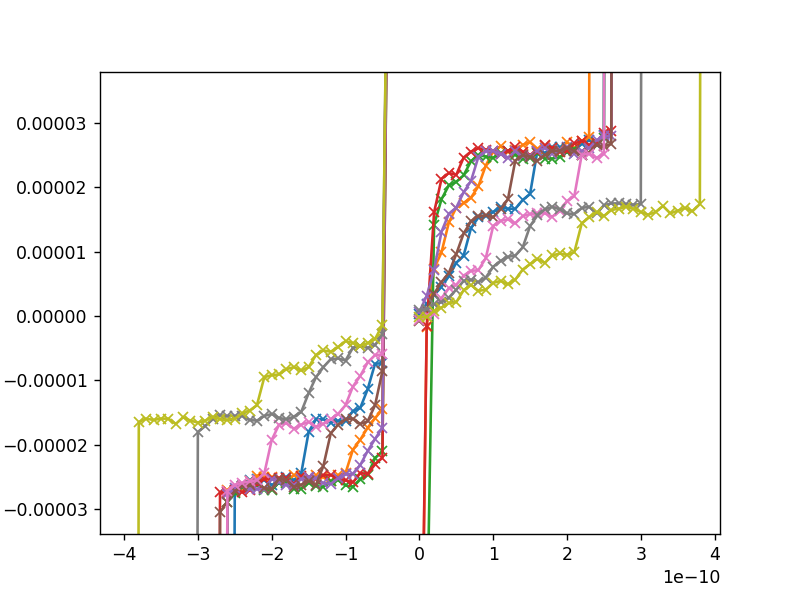

In [12]:
plt.close('all')
f,ax=plt.subplots()
for i in range(16,24+1):
    ax.plot(xy_by_id(i)[0],xy_by_id(i)[1]-(xy_by_id(i)[1][100]+xy_by_id(i)[1][300])/2, marker = 'x', ls = '-', label = 'IVc')

plt.show()

<IPython.core.display.Javascript object>


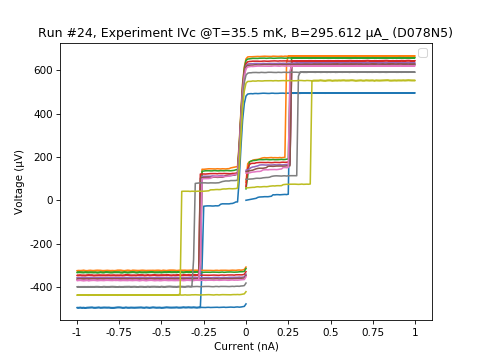

No handles with labels found to put in legend.


In [85]:
batch_plot_by_id([16,17,18,19,20,21,22,23,24])

<IPython.core.display.Javascript object>


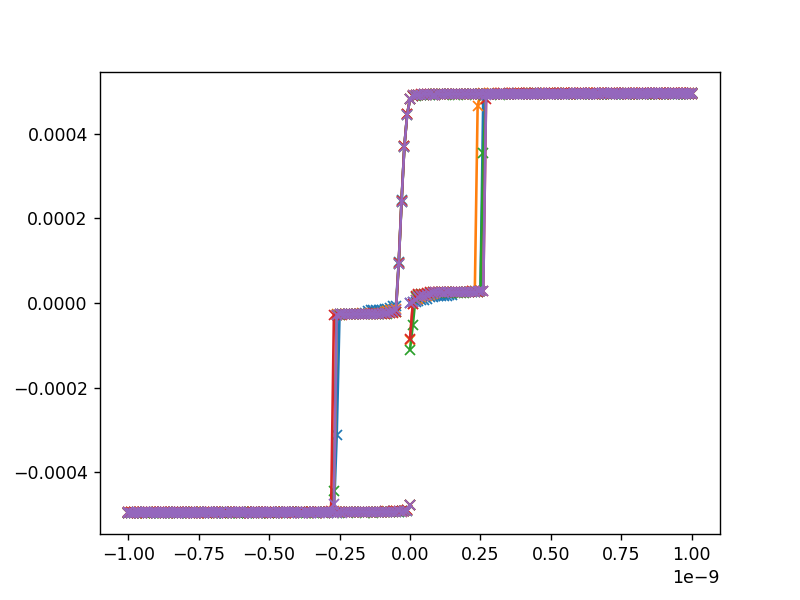

In [13]:
plt.close('all')
f,ax=plt.subplots()
for i in range(16,20+1):
    ax.plot(xy_by_id(i)[0],xy_by_id(i)[1]-(xy_by_id(i)[1][100]+xy_by_id(i)[1][300])/2, marker = 'x', ls = '-', label = 'IVc')

plt.show()

<IPython.core.display.Javascript object>


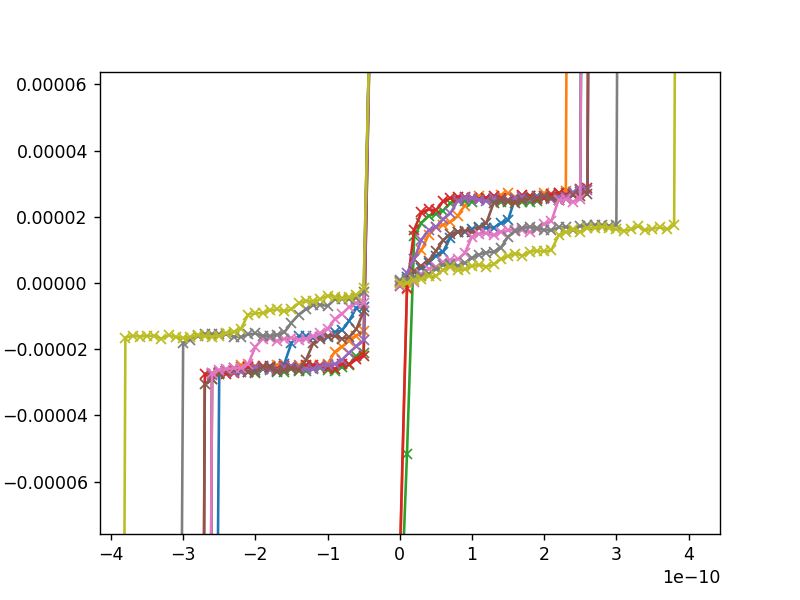

In [15]:
plt.close('all')
f,ax=plt.subplots()
for i in range(16,24+1):
    ax.plot(xy_by_id(i)[0],xy_by_id(i)[1]-(xy_by_id(i)[1][100]+xy_by_id(i)[1][300])/2, marker = 'x', ls = '-', label = 'IVc')

plt.show()

It seems that the FF is kind of 

## 1/29

<IPython.core.display.Javascript object>


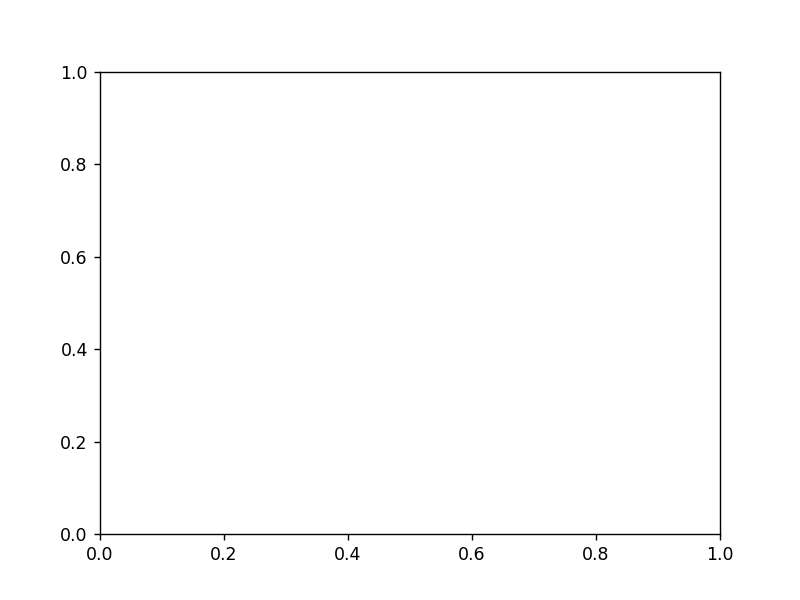

NameError: name 'exps78N5_pd' is not defined

In [16]:
plt.close('all')
f,ax=plt.subplots()

lbl = exps78N5_pd['B'][0][-6:]
l = int(len(xy_by_id(63)[0])/4)
for i,v in enumerate(exps78N5_pd['ids'][0][-6:]):
    ax.plot(xy_by_id(v)[0][:l],xy_by_id(v)[1][:l], 
            marker = 'x', ls = '-', label = si_format(lbl[i])) 
    
for i in range (2):
    ax.hlines(i*490e-6, 0,1e-9, alpha = 0.2)

# ax.set_xlim(-5e-12,85e-12)
# ax.set_ylim(-.2e-3,0.6e-3)
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


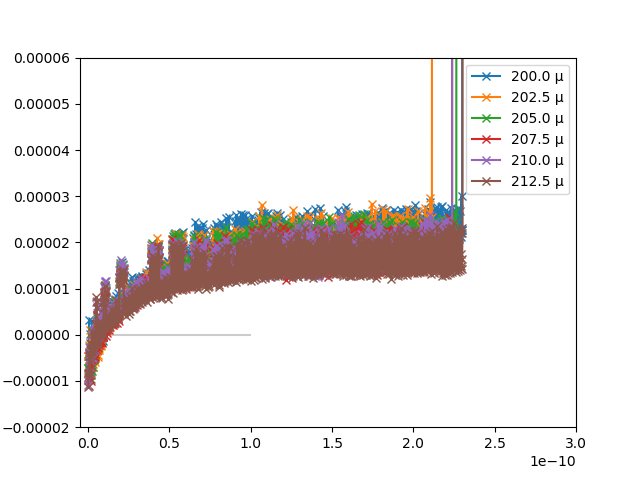

In [197]:
plt.close('all')
f,ax=plt.subplots()

lbl = exps78N5_pd['B'][2][0:6]
l = int(len(xy_by_id(94)[0])/4)
for i,v in enumerate(exps78N5_pd['ids'][2][0:6]):
    ax.plot(xy_by_id(v)[0][:l],xy_by_id(v)[1][:l], 
            marker = 'x', ls = '-', label = si_format(lbl[i])) 
for i in range (2):
    ax.hlines(i*490e-6, 0,0.1e-9, alpha = 0.2)

ax.set_xlim(-5e-12,0.3e-9)
ax.set_ylim(-.2e-4,0.6e-4)
ax.legend()
plt.show()

1. There are some "coherent jumps" between different B-fields at fast 4. What could it be?
2. The fast 6 results are the envelope of maximum of these jumps, what does that mean?


<IPython.core.display.Javascript object>


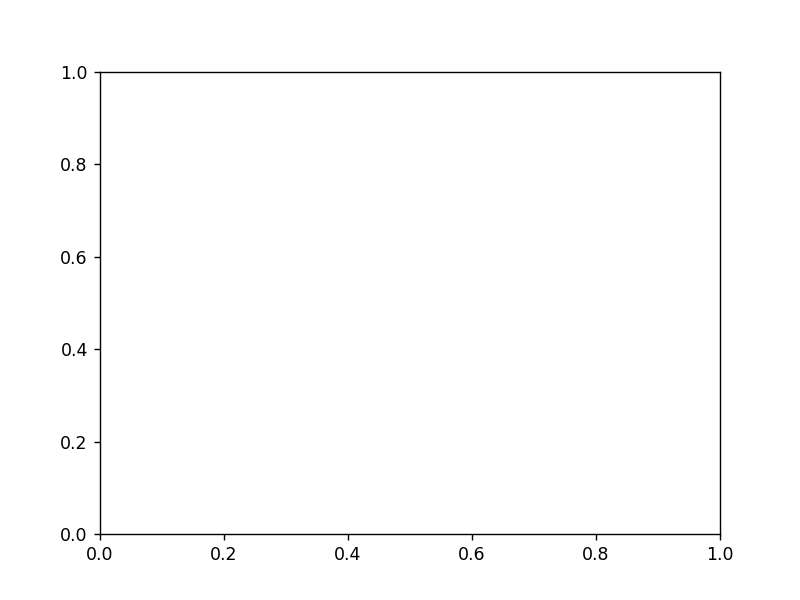

NameError: name 'exps78N5_pd' is not defined

In [11]:
plt.close('all')
f,ax=plt.subplots()

lbl = exps78N5_pd['B'][0][:]
l = int(len(xy_by_id(63)[0])/4)
for i,v in enumerate(exps78N5_pd['ids'][0][:]):
    ax.plot(xy_by_id(v)[0][:l],xy_by_id(v)[1][:l], 
            marker = 'x', ls = '-', label = si_format(lbl[i])) 
    
for i in range (2):
    ax.hlines(i*490e-6, 0,1e-9, alpha = 0.2)

# ax.set_xlim(-5e-12,85e-12)
# ax.set_ylim(-.2e-3,0.6e-3)
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


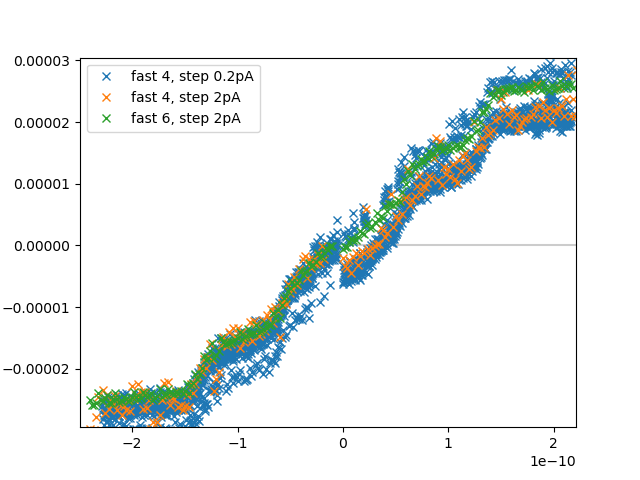

In [274]:
plt.close('all')
f,ax=plt.subplots()

lbl = ['fast 4, step 0.2pA', 'fast 4, step 2pA', 'fast 6, step 2pA']
for i,v in enumerate([114,88,92]):
    ax.plot(xy_by_id(v)[0],xy_by_id(v)[1],
            marker = 'x', ls = '', label = lbl[i]) 
    
for i in range (2):
    ax.hlines(i*490e-6, 0,1e-9, alpha = 0.2)

# ax.set_xlim(-5e-12,0.25e-9)
# ax.set_ylim(-.1e-4,0.4e-4)
ax.legend()
plt.show()

It looks like there's instability in B-field maybe?

or jumps between 'resonator' states?

## 1/30

prepare for hist meas

<IPython.core.display.Javascript object>


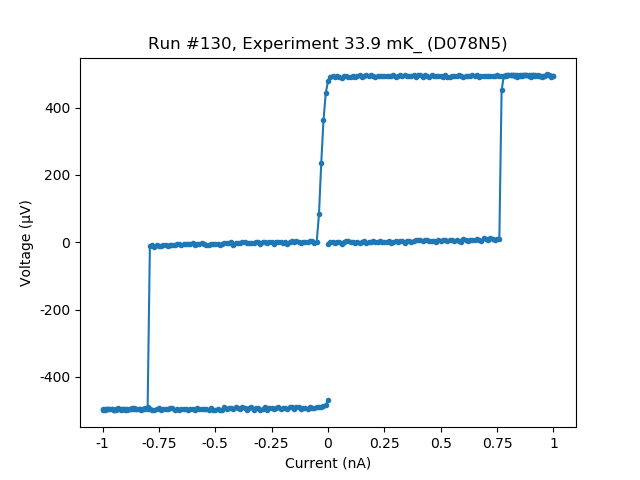

([<matplotlib.axes._subplots.AxesSubplot at 0xf346f30>], [None])

In [207]:
plot_by_id(130, marker = '.')

Hist meas, B = 0, use i_stb = 100e-12 to ensure that we are at sc branch after each scan

<IPython.core.display.Javascript object>


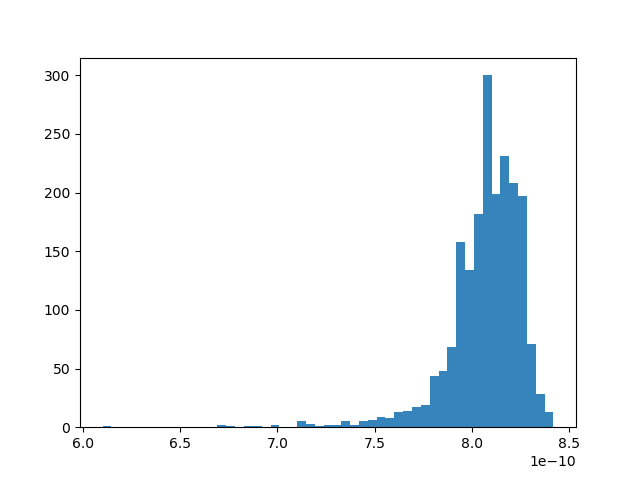

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   1.,   0.,   1.,   1.,   0.,   2.,   0.,   0.,
          5.,   3.,   1.,   2.,   2.,   5.,   2.,   5.,   6.,   9.,   8.,
         13.,  14.,  17.,  19.,  44.,  48.,  68., 158., 134., 182., 300.,
        199., 231., 208., 197.,  71.,  28.,  13.]),
 array([6.10067736e-10, 6.14616771e-10, 6.19165806e-10, 6.23714841e-10,
        6.28263876e-10, 6.32812911e-10, 6.37361946e-10, 6.41910981e-10,
        6.46460016e-10, 6.51009051e-10, 6.55558086e-10, 6.60107121e-10,
        6.64656156e-10, 6.69205191e-10, 6.73754226e-10, 6.78303261e-10,
        6.82852296e-10, 6.87401331e-10, 6.91950366e-10, 6.96499401e-10,
        7.01048436e-10, 7.05597471e-10, 7.10146506e-10, 7.14695541e-10,
        7.19244576e-10, 7.23793611e-10, 7.28342646e-10, 7.32891681e-10,
        7.37440715e-10, 7.41989750e-10, 7.46538785e-10, 7.51087820e-10,
        7.55636855e-10, 7.60185890e-10, 7.64734925e-10, 7.69283960e-10,
    

In [208]:
fig, ax = plt.subplots()

_, Isws = xy_by_id(131)


ax.hist(Isws, bins = 51, alpha = 0.9)

the histogram somehow is too narrow for this Tphys (Teff is only 1mK, Ic0 = 1nA by fitting). does it mean that this is already ~determenistic process? Fine meas of IVc to detect phase diffusion branch


In [1]:
batch_plot_by_id([130, 133], marker = '.')

NameError: name 'batch_plot_by_id' is not defined

large scan just to see Rn

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


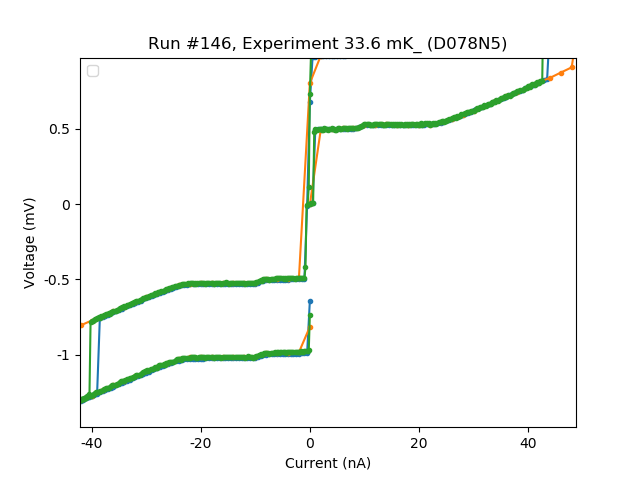

No handles with labels found to put in legend.


In [293]:
batch_plot_by_id([10,145, 146], marker = '.')

In [304]:
a = []
a += [3]
a += [5]
a

[3, 5]

### Rn, offset fit

<IPython.core.display.Javascript object>


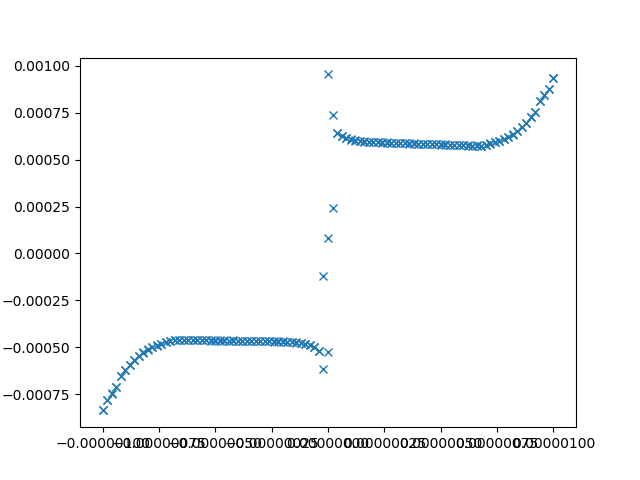

In [19]:
f,ax = plt.subplots()

I,V = xy_by_id(349)#146

dataSel = 3
l = int(len(I)/8)

ax.plot(I,V-17.22e3*I, 'x')

# I_pfit = I[1*l:3*l]
# V_pfit = V[1*l:3*l]
# a_p, b_p = np.polyfit(I_pfit, V_pfit, 1)
# ax.plot(I_pfit, I_pfit*a_p + b_p)

# I_nfit = I[5*l:7*l]
# V_nfit = V[5*l:7*l]
# a_n, b_n = np.polyfit(I_nfit, V_nfit, 1)
# ax.plot(I_nfit, I_nfit*a_n + b_n)

a_r = []
b_r = []
for i in range(1*l,3*l):
    I_rtfit = I[i:i+dataSel]
    V_rtfit = V[i:i+dataSel]
    a_rt, b_rt = np.polyfit(I_rtfit, V_rtfit, 1)
#     ax.plot(I_rtfit, I_rtfit*a_rt + b_rt)
    
    a_r += [a_rt]
    b_r += [b_rt]

# ax.plot(I[1*l:3*l], a_r)
    

# print('R_pos = {}ohm/JJ, V_off = {}V/JJ'.format(si_format(a_p/16), si_format(b_p/16)))
# print('R_neg = {}ohm/JJ, V_off = {}V/JJ'.format(si_format(a_n/16), si_format(b_n/16)))
# print('C/JJ from 1e/V_off : {}F'.format(si_format(const.e/((a_p+b_p)/2/16))))

plt.show()

<IPython.core.display.Javascript object>


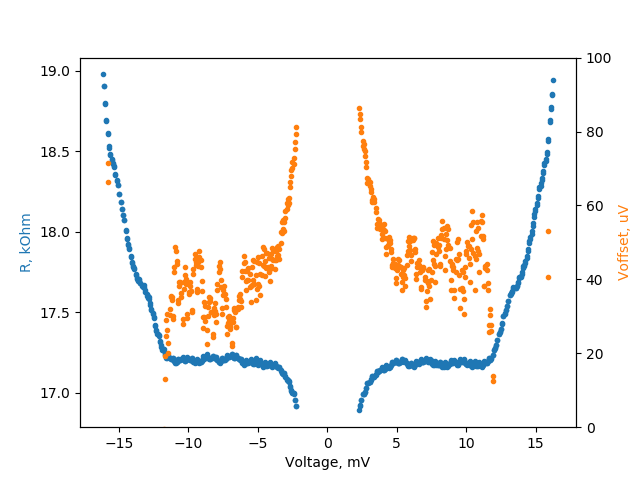

In [32]:
f,ax = plt.subplots()

I,V = xy_by_id(380)#349

wlen = 20

# ax.plot(I,V, '.')

Ispl = np.array_split(I,4)
Vspl = np.array_split(V,4)



As, Bs, Vs = [], [], []

for I, V in zip(Ispl, Vspl):
    
    I = I[10:-10]
    V = V[10:-10]
    
    


    for i in range( len(I) - wlen ):

        a, b = np.polyfit(I[i:i+wlen], V[i:i+wlen] - 70e-6, 1)        
        v = np.mean(V[i:i+wlen])

        As.append(a)
        Bs.append(b)
        Vs.append(v)


As = np.array(As)    
Bs = np.array(Bs)    
Vs = np.array(Vs)    
    
ax.plot(Vs*1e3, As/1e3, '.', ls = '')
ax.set_xlabel('Voltage, mV')
ax.set_ylabel('R, kOhm', color = 'C0')


ax2 = ax.twinx()
ax2.plot(Vs*1e3, abs(Bs/1e-6 )- 495, '.', ls = '', c = 'C1')
ax2.set_xlabel('Voltage, mV')
ax2.set_ylabel('Voffset, uV', color = 'C1')
ax2.set_ylim(0, 100)

plt.show()






<IPython.core.display.Javascript object>


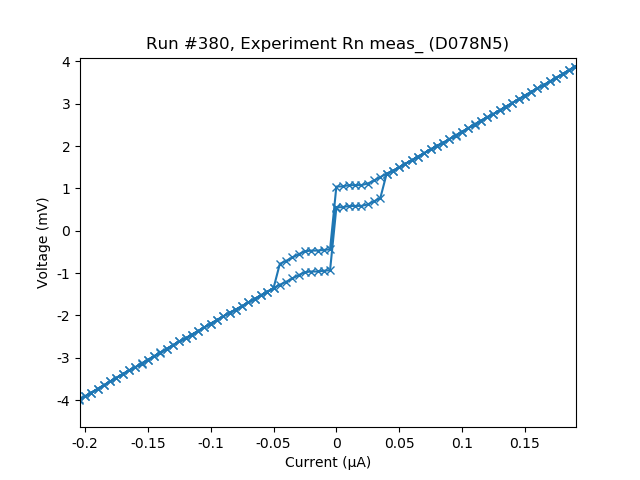

([<matplotlib.axes._subplots.AxesSubplot at 0x9a83df0>], [None])

In [22]:
plot_by_id(380, marker = 'x')

Use single SQUID to review source noise again.

In [14]:
# uses fast 4 if not specified
lbl = ['KE, delay .1s, 50ohm', 'KE, delay 1s, 50ohm, 13.39kohm',
       'AWG, delay .1s, 1Gohm', 'AWG, delay 1s, 1Gohm, 35.6Kohm',
#        'Keysight, delay .1s, 1Gohm',
       '']

batch_plot_by_id([167,150,#KE, 92 for FF, 152 for ZF fast 6
                  157,161#AWG, 160 for ZF fast 6
                  ], marker = '.', labels = lbl)


NameError: name 'batch_plot_by_id' is not defined

<IPython.core.display.Javascript object>


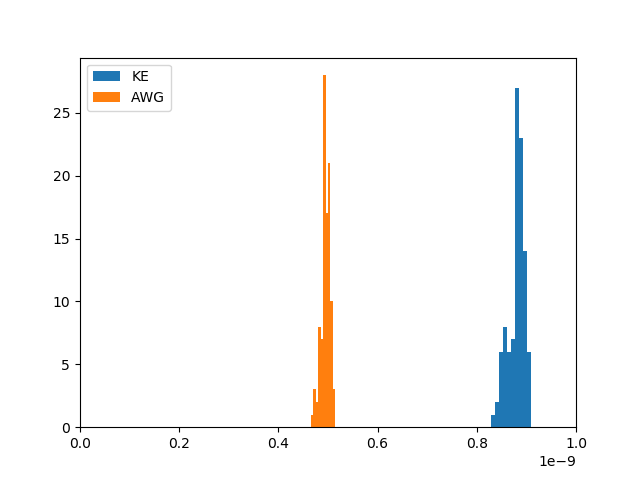

In [272]:
plt.close('all')
plt.hist(xy_by_id(166)[1], label = 'KE')
plt.hist(xy_by_id(164)[1], label = 'AWG')
plt.xlim(0,1e-9)
plt.legend()
plt.show()

id 155 corresponding to some unknown connection to AWG, which shows huge asymmetry and smaller I_SW. After adjustment the curve (red one above) looks more or less okay, but still AWG performs worse than KE. Also the reason for a voltage offset is still unknown

## 2/3

checking the source again for noise level.

<IPython.core.display.Javascript object>


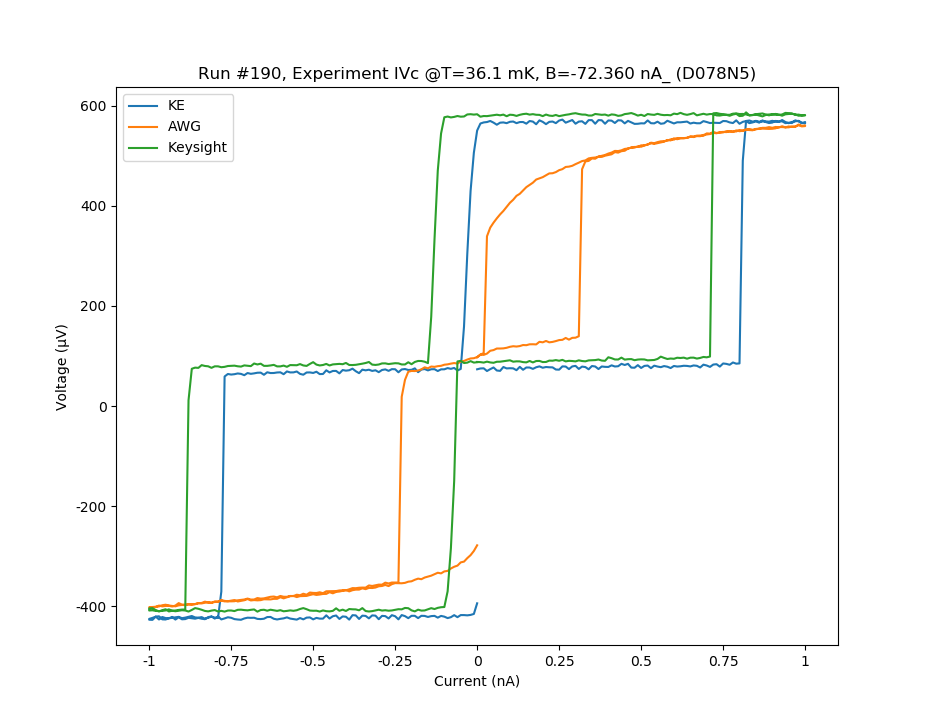

In [105]:
lbl = ['KE', 'AWG', 'Keysight']
batch_plot_by_id([172,182,190], labels = lbl)#

FF data, it seems that the KE is 

<IPython.core.display.Javascript object>


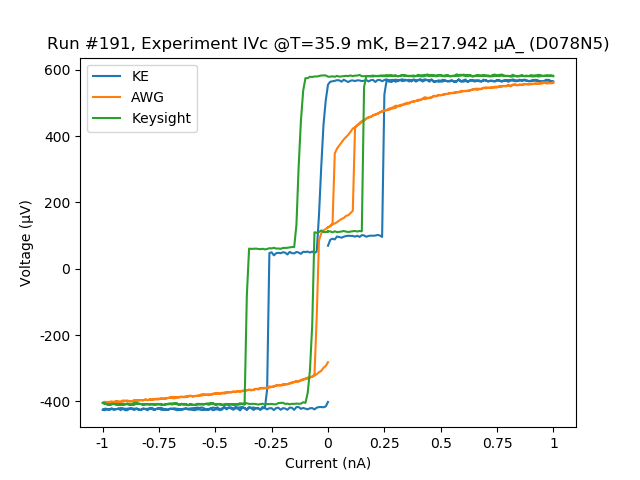

In [73]:
lbl = ['KE', 'AWG', 'Keysight']
batch_plot_by_id([173,183,191], labels = lbl)#

high resolution to extract R0 for FF

<IPython.core.display.Javascript object>


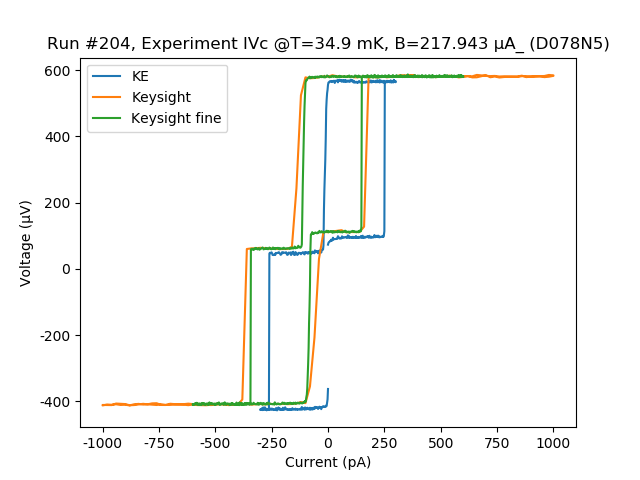

In [40]:
# full frustr

lbl = ['KE','Keysight','Keysight fine']
batch_plot_by_id([196,203, 204], labels = lbl)#

<IPython.core.display.Javascript object>


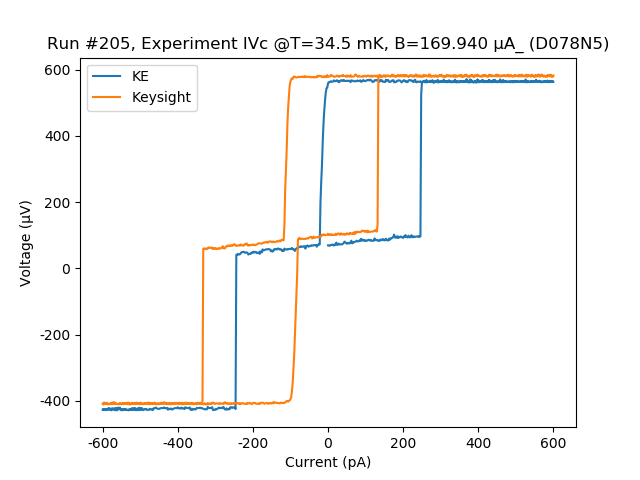

In [48]:
# B = 170

lbl = ['KE', 'Keysight']
batch_plot_by_id([206, 205], labels = lbl)#

<IPython.core.display.Javascript object>


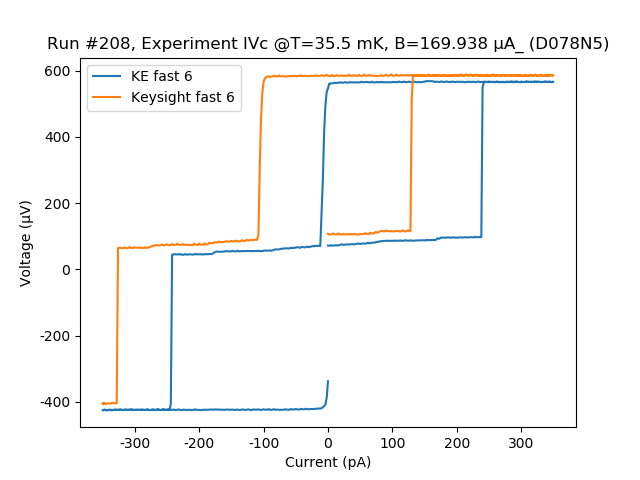

In [53]:
# B = 170 fast 6

lbl = ['KE fast 6', 'Keysight fast 6']
batch_plot_by_id([207, 208], labels = lbl)#

<IPython.core.display.Javascript object>


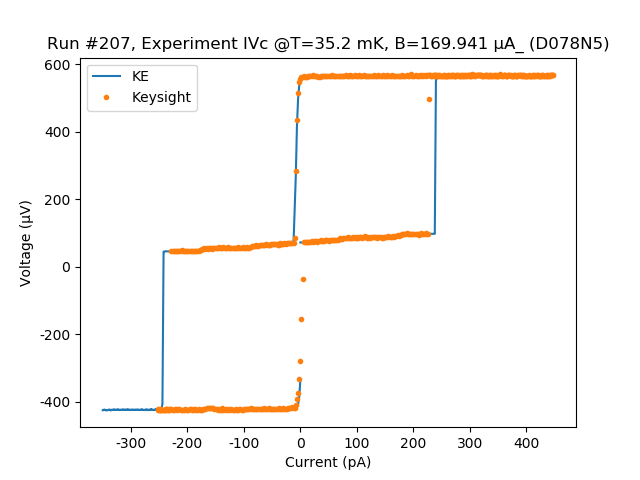

In [71]:
fig, ax = plt.subplots()



plot_by_id(207, ax, label = 'KE')


I, V = xy_by_id(208)


Ioff = -98e-12
Voff = 19e-6

ax.plot(I - Ioff, V - Voff, '.', label = 'Keysight')

ax.legend()

## 2/10

check again for source comparison

<IPython.core.display.Javascript object>


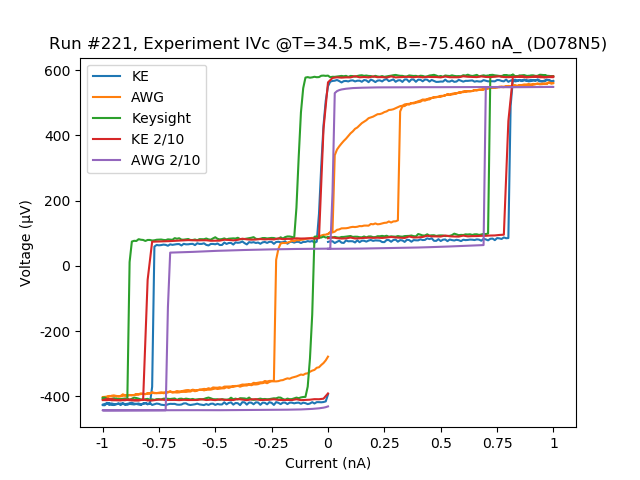

In [195]:
lbl = ['KE', 'AWG', 'Keysight', 'KE 2/10', 'AWG 2/10']
batch_plot_by_id([172,182,190, 210, 221], labels = lbl)#

<IPython.core.display.Javascript object>


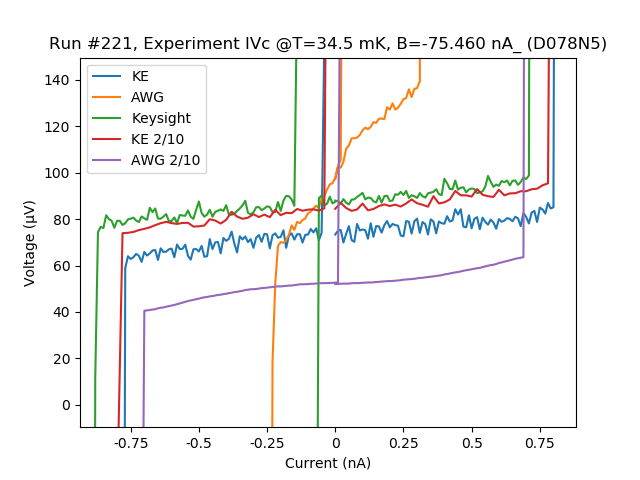

In [196]:
lbl = ['KE', 'AWG', 'Keysight', 'KE 2/10', 'AWG 2/10']
batch_plot_by_id([172,182,190, 210, 221], labels = lbl)#

ok, so KE has comparable results, check AWG now

<IPython.core.display.Javascript object>


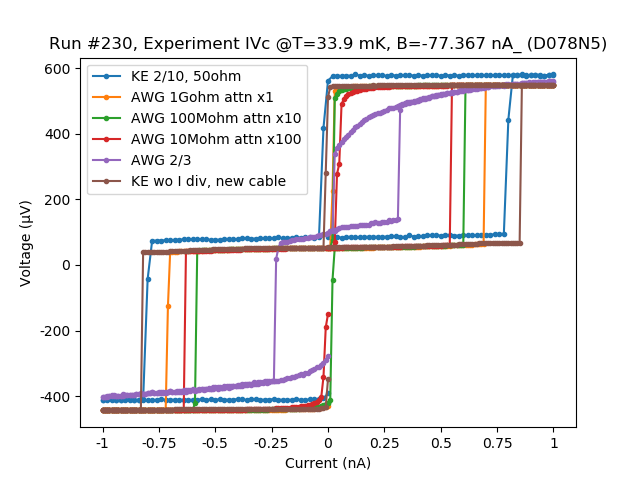

In [250]:
lbl = ['KE 2/10, 50ohm', 'AWG 1Gohm attn x1', 'AWG 100Mohm attn x10',
       'AWG 10Mohm attn x100', 'AWG 2/3', 'KE wo I div, new cable']
batch_plot_by_id([210, 221, 226, 225, 182,230], labels = lbl, marker = '.')#

Keithley seems to have best I_SW still, but AWG no longer has distorted hysterisis. What causes such time-dep. variation?

<IPython.core.display.Javascript object>


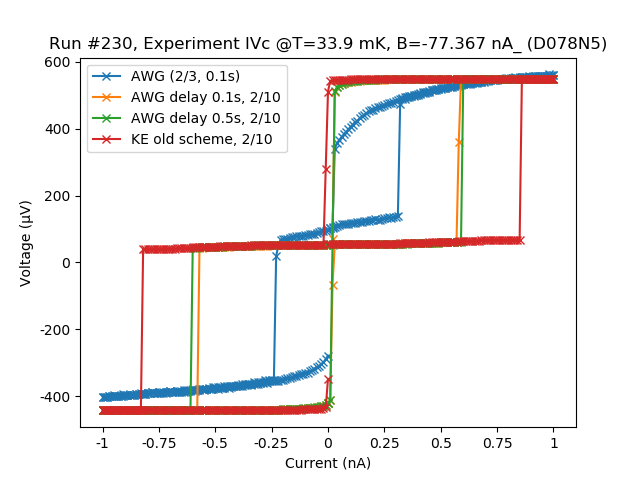

In [252]:
#'AWG 100Mohm attn x10'
lbl = ['AWG (2/3, 0.1s)', 'AWG delay 0.1s, 2/10', 
       'AWG delay 0.5s, 2/10', 'KE old scheme, 2/10']
batch_plot_by_id([182, 227, 228, 230], labels = lbl, marker = 'x')#

<IPython.core.display.Javascript object>


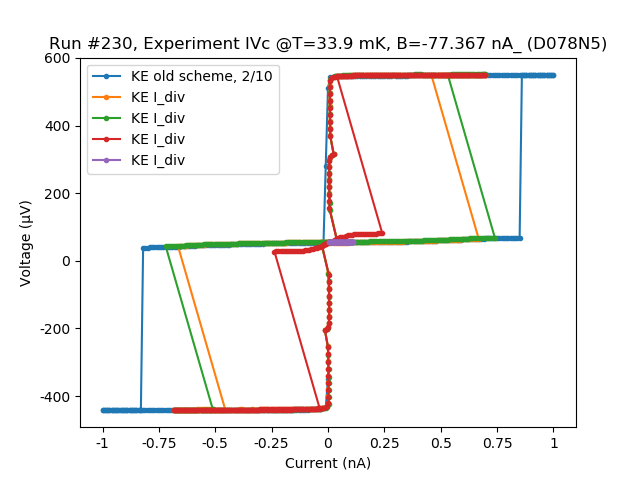

In [213]:
f, ax = plt.subplots()

plot_by_id(230, axes = ax, marker = '.',ls = '-',  label = 'KE old scheme, 2/10')

R = 2.2e6
r = 10.1e3

id_ke = [232, 233, 234,236]#216

for idx in id_ke:
    I, V = xy_by_id(idx)
    It = (I*r-(V-68e-6))/(r+R)
    ax.plot(It, V, marker = '.', ls = '-', label='KE I_div')

ax.legend()

<IPython.core.display.Javascript object>


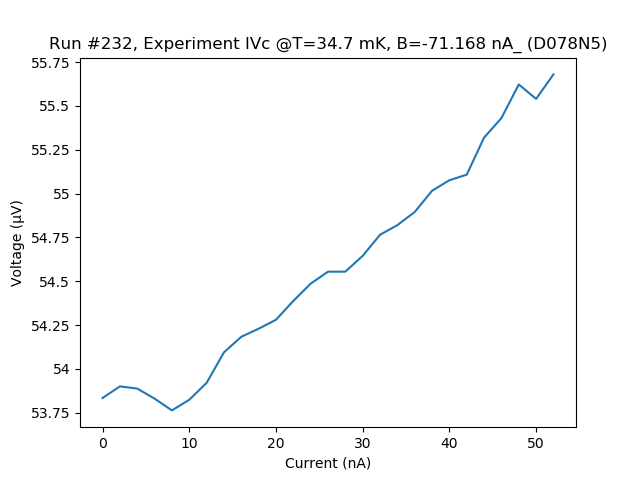

([<matplotlib.axes._subplots.AxesSubplot at 0x1555fc30>], [None])

In [187]:
plot_by_id(232)

## 2/11

<IPython.core.display.Javascript object>


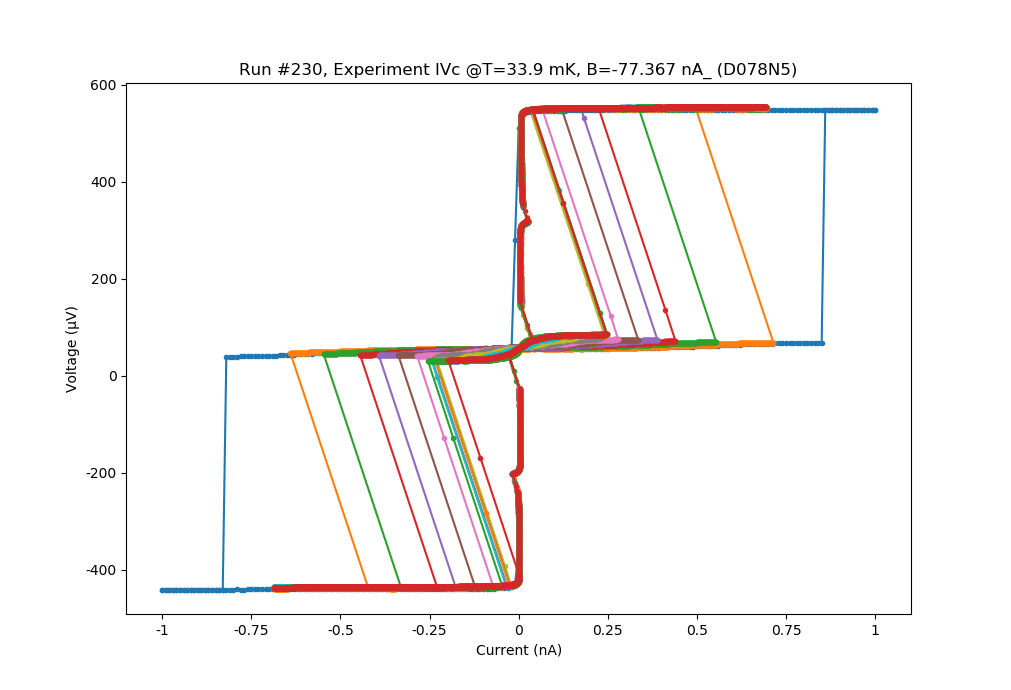

load line slope: -2.3 Mohm


In [41]:
f, ax = plt.subplots()

plot_by_id(230, axes = ax, marker = '.',ls = '-',  label = 'KE old scheme, 2/10')

R = 2.2e6
r = 10.1e3

id_ke = range(237, 262+1)[::2]

for idx in id_ke:
    I, V = xy_by_id(idx)
    It = (I*r-(V-68e-6))/(r+R)
    ax.plot(It, V, marker = '.', ls = '-', label='KE I_div')

# ax.legend()
print('load line slope: {}ohm'.format(si_format(-2274744)))

In [ ]:
         [range(237, 262+1),  32e-3,  cos_to_B(np.linspace(1,0,26)),       'fast 6, I_div'],
         [range(263, 288+1),  32e-3,  cos_to_B(np.linspace(1,0,26)),       'AWG att 1'],
         [range(289, 314+1),  32e-3,  cos_to_B(np.linspace(1,0,26)),       'AWG att 10'],


<IPython.core.display.Javascript object>


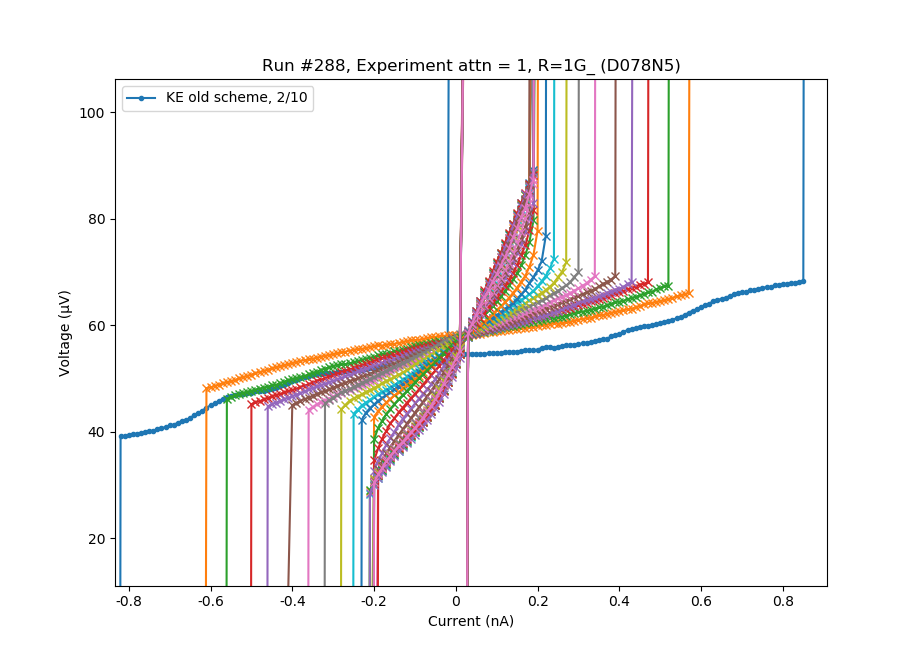

In [256]:
f, ax = plt.subplots()

plot_by_id(230, axes = ax, marker = '.',ls = '-',  label = 'KE old scheme, 2/10')


batch_plot_by_id(range(263, 288+1), ax = ax, marker = 'x')

compare awg with keithley, diff B

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


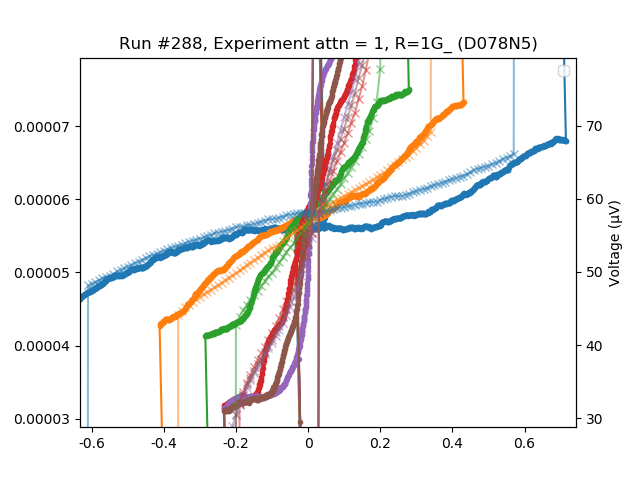

load line slope: -2.3 Mohm


No handles with labels found to put in legend.


In [326]:
f, ax = plt.subplots()

# plot_by_id(230, axes = ax, marker = '.',ls = '-',  label = 'KE old scheme, 2/10')

R = 2.2e6
r = 10.1e3

id_ke = range(237, 262+1)[::5]

for idx in id_ke:
    I, V = xy_by_id(idx)
    It = (I*r-(V-68e-6))/(r+R)
    ax.plot(It, V, marker = '.', ls = '-')

# ax.legend()
print('load line slope: {}ohm'.format(si_format(-2274744)))


ax2 = ax.twinx()
batch_plot_by_id(range(263, 288+1)[::5], ax = ax2, marker = 'x', alpha = 0.5)

compare awg 1 and 10 att, diff B

<IPython.core.display.Javascript object>


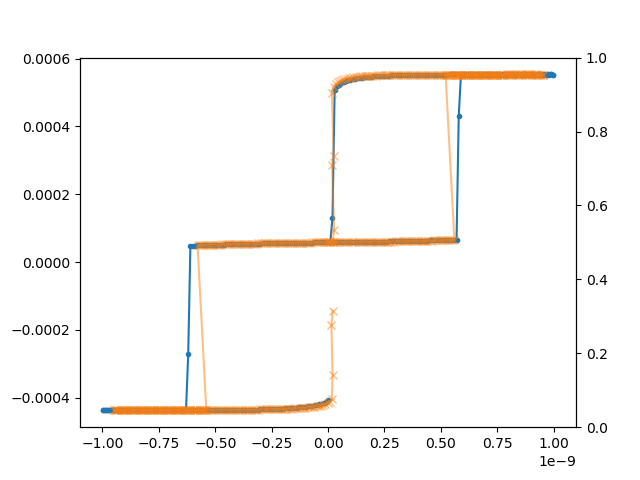

In [279]:
f, ax = plt.subplots()

idx = 263
R = 1e9
I, V = xy_by_id(idx)
It = I - (V-68e-6)/R
ax.plot(It, V, marker = '.', ls = '-')

ax2 = ax.twinx()

idx = 320
R = 1e7
I, V = xy_by_id(idx)
It = I - (V-68e-6)/R
ax.plot(It, V-1e-6, marker = 'x', ls = '-', alpha = 0.5)

# plot_by_id(320, axes = ax)

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


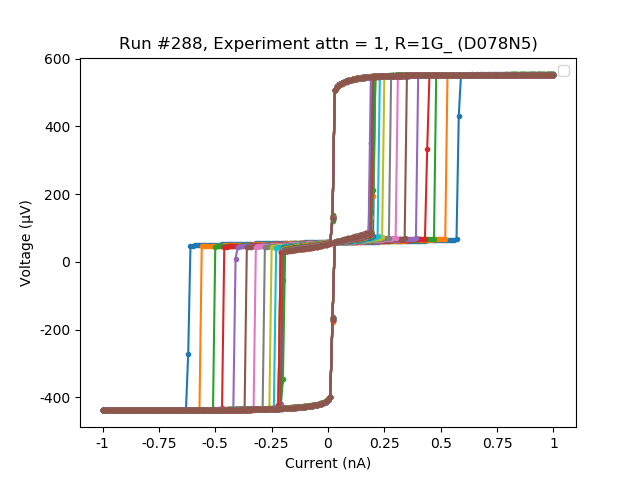

No handles with labels found to put in legend.


In [325]:
batch_plot_by_id(range(263, 288+1),  marker = '.', alpha = 1)

<IPython.core.display.Javascript object>


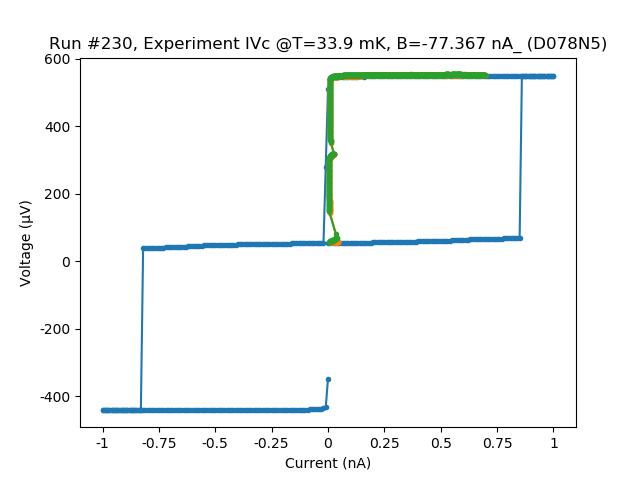

In [229]:
f, ax = plt.subplots()

plot_by_id(230, axes = ax, marker = '.',ls = '-',  label = 'KE old scheme, 2/10')

R = 2.2e6
r = 10.1e3

id_ke = [237,262]

for idx in id_ke:
    I, V = xy_by_id(idx)
    It = (I*r-(V-68e-6))/(r+R)
    l = int(len(It)/4)
    ax.plot(It[l:2*l], V[l:2*l], marker = '.', ls = '-', label='KE I_div')

<IPython.core.display.Javascript object>


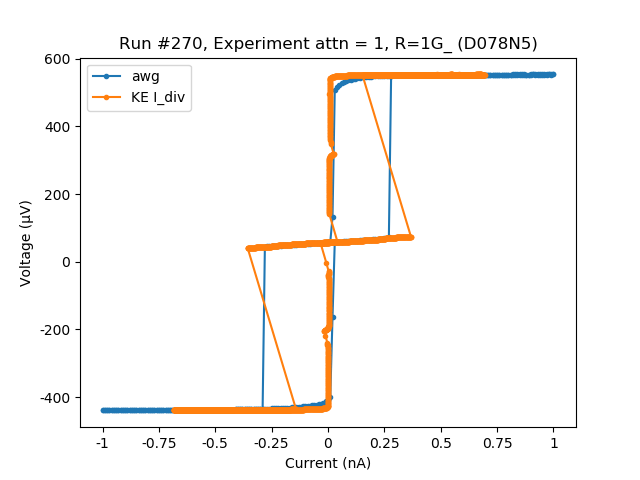

In [247]:
f, ax = plt.subplots()


i = 7



plot_by_id(263+i, axes = ax, marker = '.',ls = '-',  label = 'awg')

R = 2.2e6
r = 10.1e3



id_ke = [237+i]

for idx in id_ke:
    I, V = xy_by_id(idx)
    It = (I*r-(V-68e-6))/(r+R)
    
    ax.plot(It, V -1e-6, marker = '.', ls = '-', label='KE I_div')
  

ax.legend()

<IPython.core.display.Javascript object>


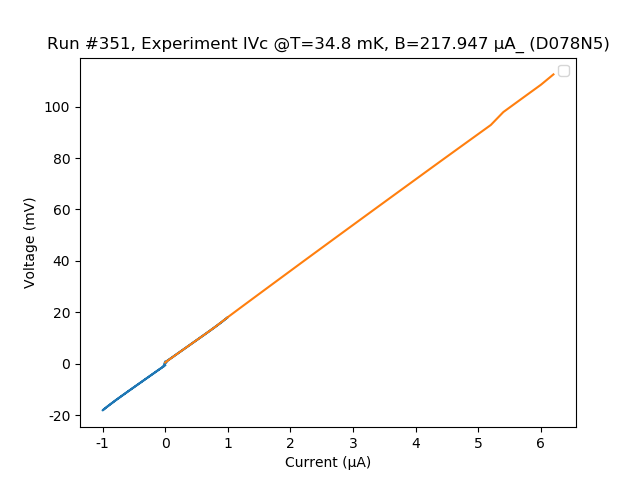

No handles with labels found to put in legend.


In [290]:
batch_plot_by_id([349, 351])